In [1]:
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import probeinterface.io as pio
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.widgets as sw
import spikeinterface as si
from probeinterface import Probe
from probeinterface.plotting import plot_probe
import spikeinterface.sorters as ss
from pprint import pprint
ss.Kilosort3Sorter.set_kilosort3_path(r'D:\toolboxes\Kilosort-main\Kilosort-main')
pprint(ss.installed_sorters())

Setting KILOSORT3_PATH environment variable for subprocess calls to: D:\toolboxes\Kilosort-main\Kilosort-main
RUNNING SHELL SCRIPT: C:\Users\fmora103\AppData\Local\Temp\tmp_shellscriptr_qon2n3\script.bat
['kilosort3', 'tridesclous']


In [2]:
file_paths = r'C:\Users\fmora103\Desktop\Nastaran Data\M6April.raw'
sampling_frequency = 20000
num_channels = 3
recording = se.BinaryRecordingExtractor(file_paths, sampling_frequency, num_channels, 'int16')
print(recording)

BinaryRecordingExtractor: 3 channels - 1 segments - 20.0kHz - 16142.076s
  file_paths: ['C:\\Users\\fmora103\\Desktop\\Nastaran Data\\M6April.raw']


In [12]:
n = 4
positions = np.zeros((n, 2))
positions[0] = 10, 0
positions[1] = 10, 60
positions[2] = -10, 60
positions[3] = 30, 60
probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 5})
polygon = [(-20, -30), (10, -100), (40, -30), (40, 190), (-20, 190)]
probe.set_planar_contour(polygon)
df = probe.to_dataframe()
df

,x,y,contact_shapes,radius,shank_ids,contact_ids
0,10.0,0.0,circle,5.0,,
1,10.0,60.0,circle,5.0,,
2,-10.0,60.0,circle,5.0,,
3,30.0,60.0,circle,5.0,,


In [3]:
n = 3
positions = np.zeros((n, 2))
positions[0] = 10, 0
positions[1] = 10, 60
positions[2] = 30, 60
probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 5})
polygon = [(-20, -30), (10, -100), (40, -30), (40, 190), (-20, 190)]
probe.set_planar_contour(polygon)
df = probe.to_dataframe()
df

,x,y,contact_shapes,radius,shank_ids,contact_ids
0,10.0,0.0,circle,5.0,,
1,10.0,60.0,circle,5.0,,
2,30.0,60.0,circle,5.0,,


(<matplotlib.collections.PolyCollection at 0x23afac3e130>,
 <matplotlib.collections.PolyCollection at 0x23afac73910>)

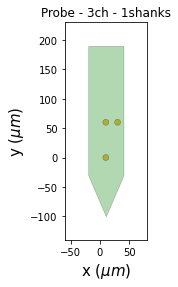

In [4]:
probe.set_device_channel_indices(np.arange(3))
recording = recording.set_probe(probe)
plot_probe(probe)

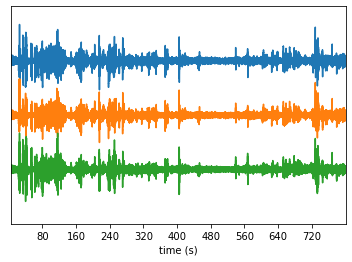

In [5]:
w_ts1 = sw.plot_timeseries(recording, time_range=(5, 800))

In [5]:
default_TDC_params = ss.TridesclousSorter.default_params()
default_TDC_params['detect_threshold'] = 5
default_TDC_params['freq_min'] = 300
default_TDC_params['freq_max'] = 8000
default_TDC_params['common_ref_removal'] = 'True'
print(default_TDC_params)

{'freq_min': 300, 'freq_max': 8000, 'detect_sign': -1, 'detect_threshold': 5, 'common_ref_removal': 'True', 'nested_params': None, 'total_memory': '500M', 'n_jobs_bin': 1}


In [6]:
sorting_TDC_5 = ss.run_tridesclous(recording=recording, output_folder='testt11',**default_TDC_params)
sorting_TDC_5.get_unit_ids()

array([0, 1], dtype=int64)

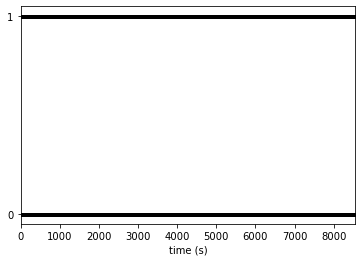

In [7]:
w_rs = sw.plot_rasters(sorting_TDC_5)

In [8]:
folder = 'waveforms_mearec'
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=8000)
recording_f.annotate(is_filtered=True)
we = si.extract_waveforms(recording_f, sorting_TDC_5, folder,
                          load_if_exists=True,
                          ms_before=1, ms_after=2., max_spikes_per_unit=500,
                          n_jobs=1, chunk_size=30000)
print(we)

Setting 'return_scaled' to False
WaveformExtractor: 3 channels - 2 units - 1 segments
  before:20 after:40 n_per_units:500


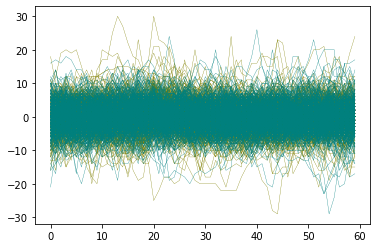

In [9]:
colors = ['Olive', 'Teal']

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_TDC_5.unit_ids[:3]):
    wf = we.get_waveforms(unit_id)
    color = colors[i]
    ax.plot(wf[:, :, 2].T, color=color, lw=0.3)

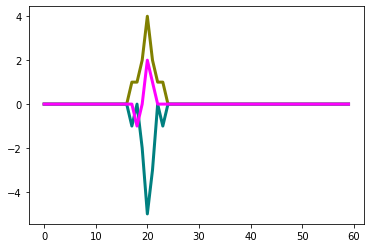

In [14]:
fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_TDC_5.unit_ids[:3]):
    template = we.get_template(unit_id)
    color = colors[i]
    ax.plot(template[:, 0].T, color=color, lw=3)

WaveformPrincipalComponent: 3 channels - 1 segments
  mode:by_channel_local n_components:3
(500, 3, 3)
(500, 3, 3)
(500, 3, 3)


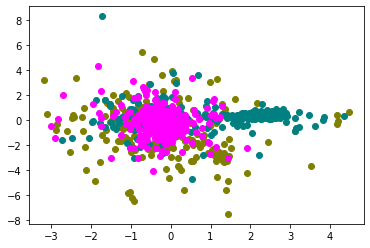

In [18]:
pc = st.compute_principal_components(we, load_if_exists=True,
                                     n_components=3, mode='by_channel_local')
print(pc)

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_TDC_5.unit_ids[:3]):
    comp = pc.get_components(unit_id)
    print(comp.shape)
    color = colors[i]
    ax.scatter(comp[:, 0, 2], comp[:, 1, 2], color=color)

In [10]:
from spikeinterface.exporters import export_to_phy
output_folder = 'phy_folder'
export_to_phy(we, output_folder)

write_binary_recording with n_jobs 1  chunk_size None
Setting 'return_scaled' to False
Run:
phy template-gui  c:\Users\fmora103\iCloudDrive\Desktop\Nastaran\Pattern-Seperation\Pattern-Seperation\phy_folder\params.py


In [7]:
default_KS_params = ss.Kilosort3Sorter.default_params()
print(default_KS_params)

{'detect_threshold': 6, 'projection_threshold': [9, 9], 'preclust_threshold': 8, 'car': True, 'minFR': 0.2, 'minfr_goodchannels': 0.2, 'nblocks': 5, 'sig': 20, 'freq_min': 300, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'keep_good_only': False, 'total_memory': '500M', 'n_jobs_bin': 1}


In [24]:
sorting_KS = ss.run_kilosort3(recording=recording)
sorting_KS.get_unit_ids()

KilosortBase._run_from_folder <class 'spikeinterface.sorters.kilosort3.kilosort3.Kilosort3Sorter'>
RUNNING SHELL SCRIPT: kilosort3_output\run_kilosort3.bat
Traceback (most recent call last):
  File "c:\Users\fmora103\Anaconda3\envs\SI\lib\site-packages\spikeinterface\sorters\basesorter.py", line 200, in run_from_folder
    SorterClass._run_from_folder(output_folder, sorter_params, verbose)
  File "c:\Users\fmora103\Anaconda3\envs\SI\lib\site-packages\spikeinterface\sorters\kilosortbase.py", line 42, in _run_from_folder
    raise Exception(f'{cls.sorter_name} returned a non-zero exit code')
Exception: kilosort3 returned a non-zero exit code



SpikeSortingError: Spike sorting failed. You can inspect the runtime trace in kilosort3_output/spikeinterface_log.json

In [19]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: C:\Users\fmora103\AppData\Local\Temp\tmp_shellscriptptbmj7in\script.bat


['tridesclous']